## Solution for yandex machine learning iprofi competition 2021

In [29]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns

In [50]:
data_path = 'data'
submission_path = 'submission'

In [57]:
def get_sub_number():
    max_number = sorted(os.listdir(submission_path), key=lambda x: int(x.split('_')[0]))[-1] + 1
    return max_number

def create_submission(predictions):
    
    if not os.path.isdir(submission_path):
        os.mkdir(submission_path)
        
    submission = test.copy()
    submission['NTG'] = predictions
    
    sub_number = 1 if not os.listdir(submission_path) else get_sub_number()
    
    save_path = os.path.join(submission_path, '{}_submission.csv'.format(sub_number))
    
    submission.to_csv(save_path, index=False)

In [192]:
train = pd.read_csv(os.path.join(data_path, 'Training_wells.csv'))
test = pd.read_csv(os.path.join(data_path, 'Empty_part.csv'))

In [10]:
print('Train shape: {}'.format(train.shape))
print('Test shape: {}'.format(test.shape))

Train shape: (138, 4)
Test shape: (1242, 3)


In [6]:
train.head()

,Well,X,Y,NTG
0,201-907,201,907,0.2006
1,201-914,201,914,0.3624
2,201-924,201,924,0.4381
3,202-922,202,922,0.4289
4,202-925,202,925,0.4021


In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 138 entries, 0 to 137
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Well    138 non-null    object 
 1   X       138 non-null    int64  
 2   Y       138 non-null    int64  
 3   NTG     138 non-null    float64
dtypes: float64(1), int64(2), object(1)
memory usage: 4.4+ KB


In [15]:
# Well column is id, coombination of X and Y
assert train.Well.nunique() == train.shape[0]
assert test.Well.nunique() == test.shape[0]

Mean: 0.3257195652173913


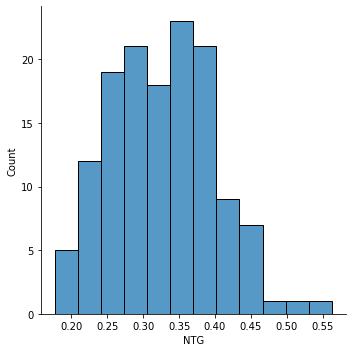

In [41]:
print('Mean: {}'.format(train['NTG'].mean()))
sns.displot(train['NTG'], bins=12)

<AxesSubplot:xlabel='X', ylabel='Y'>

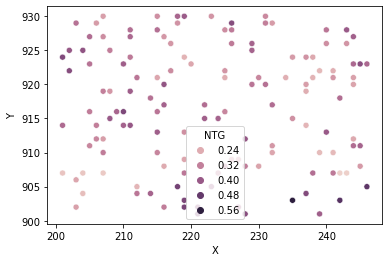

In [178]:
sns.scatterplot(data=train, x='X', y='Y', hue='NTG')

## Submit 1 - baseline

In [58]:
prediction = train['NTG'].mean()
create_submission(prediction)

## Submit 2

In [163]:
x_not_in_train = []
y_not_in_train = []
for x, y in zip(test.X, test.Y):
    if x not in train.X.values and x not in x_not_in_train:
        x_not_in_train.append(x)
    if y not in train.Y.values and y not in y_not_in_train:
        y_not_in_train.append(y)

In [165]:
print('X not in train: {}'.format(x_not_in_train))
print('Y not in train: {}'.format(y_not_in_train))

X not in train: [213, 233, 236]
Y not in train: []


In [170]:
# group_x = train.groupby(by='X').agg({'NTG':'mean'})
# group_x.reset_index(inplace=True)
# group_x.columns = ['X', 'NTG_X_mean']

# group_y = train.groupby(by='Y').agg({'NTG':'mean'})
# group_y.reset_index(inplace=True)
# group_y.columns = ['Y', 'NTG_Y_mean']


# train = pd.merge(train, group_x, on='X', how='left')

# train = pd.merge(train, group_y, on='Y', how='left')


# group_x = train.groupby(by='X').agg({'NTG':'median'})
# group_x.reset_index(inplace=True)
# group_x.columns = ['X', 'NTG_X_median']

group_y = train.groupby(by='Y').agg({'NTG':'median'})
group_y.reset_index(inplace=True)
group_y.columns = ['Y', 'NTG_Y_median']

# train = pd.merge(train, group_x, on='X', how='left')

train = pd.merge(train, group_y, on='Y', how='left')

<AxesSubplot:xlabel='X', ylabel='Y'>

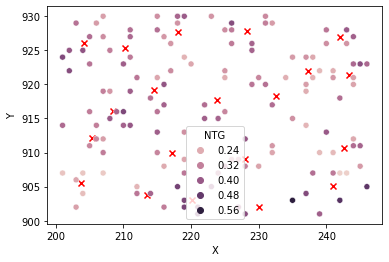

In [191]:
from sklearn.cluster import KMeans

model = KMeans(n_clusters=20)
model.fit(train[['X', 'Y']])

plt.scatter(model.cluster_centers_[:, 0], model.cluster_centers_[:, 1], marker='x', color='red')
sns.scatterplot(data=train, x='X', y='Y', hue='NTG')

In [196]:
train['cluster'] = model.labels_

group = train.groupby(by='cluster').agg({'NTG':'mean'})
group.reset_index(inplace=True)
group.columns = ['cluster', 'NTG_cluster_mean']

train = pd.merge(train, group, on='cluster', how='left')

In [197]:
train

,Well,X,Y,NTG,cluster,NTG_cluster_mean
0,201-907,201,907,0.2006,11,0.218567
1,201-914,201,914,0.3624,1,0.314583
2,201-924,201,924,0.4381,5,0.355600
3,202-922,202,922,0.4289,5,0.355600
4,202-925,202,925,0.4021,5,0.355600
...,...,...,...,...,...,...
133,245-908,245,908,0.2719,18,0.297271
134,245-911,245,911,0.3780,18,0.297271
135,245-923,245,923,0.4239,13,0.317375
136,246-905,246,905,0.4900,0,0.357012


In [199]:
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error


x_train, x_val, y_train, y_val = train_test_split(train.drop(['Well', 'NTG'], axis=1),
                                                  train['NTG'],
                                                  test_size=0.2,
                                                  random_state=42)

model = XGBRegressor(objective='reg:squarederror')

model.fit(x_train, y_train)
predictions = model.predict(x_val)

baseline = np.ones(shape=(predictions.shape)) * y_val.mean()

print('RMSE: {}'.format(np.sqrt(mean_squared_error(y_val, predictions))))
print('Baseline RMSE: {}'.format(np.sqrt(mean_squared_error(y_val, baseline))))

RMSE: 0.06822603639639348
Baseline RMSE: 0.06722763293543839
